In [3]:
import world as wrld
import DDPG as d
import torch
import numpy as np
import noise
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

writer = SummaryWriter()

env = wrld.World()

agent = d.DDPGagent(state_dim=5, 
                      n_actor=32, 
                      action_dim=1, 
                      n_critic=32, 
                      batch_size=32, 
                      learn_every=10, 
                      tau=0.005)

exploration_noise = noise.ParameterNoise(initial_std = 0.2)
replay_buffer_size = 1000
env.risk_aversion = 0.1

In [4]:
def train_and_adapt(delta_t: float, 
                    trading_cost: float,
                    n: int, 
                    strike: float =100, 
                    in_spot: float =100):
    
    env.trading_cost = trading_cost
    env.delta_t = delta_t
    m = int(env.maturity/env.delta_t) - 1

    t = [] # one episode

    unperturbed_actions = []
    perturbed_actions = []

    cum_rew = []
    pnl_dist = []
    var = []

    delta = env.bs_hedge(t=0, spot=in_spot)
    option_price = env.price(t=0, spot=in_spot)

    for episode in range(1, n+1):
        pnl = 0
        cumulative_reward = 0
        state_ = wrld.State(env.maturity, 0, np.log(in_spot/strike), delta, option_price)
        state = torch.tensor([*state_]).float().reshape(-1,1).t()

        nbr_actions = len(perturbed_actions)

        if nbr_actions > int(replay_buffer_size*(3/4)):
            u_a = torch.FloatTensor(unperturbed_actions)
            p_a = torch.FloatTensor(perturbed_actions)
            ddpg_distance = exploration_noise.ddpg_distance(u_a, p_a)
            exploration_noise.adapt(ddpg_distance)

            unperturbed_actions = [] 
            perturbed_actions = []

        agent.perturb_actor_parameters(param_noise=exploration_noise)

        action_0 = agent.act(state, agent.perturbed_actor).detach().numpy()[0,0]
        
        unperturbed_action_0 = agent.act(state, agent.actor).detach().numpy()[0,0]

        target_action = agent.act(state, agent.actor_target).detach().numpy()[0,0]

        perturbed_actions += [action_0]
        unperturbed_actions += [unperturbed_action_0]

        transition = next(env.get_transition(state_, action_0))

        t = [transition]

        target_next_state = wrld.State(ttm=transition.next_state.ttm, 
                                       holding=target_action, 
                                       log_price=transition.next_state.log_price, 
                                       delta=transition.next_state.delta, 
                                       option_price=transition.next_state.option_price)

        target_reward = env.pnl_reward(state=state_, next_state=target_next_state)

        pnl += target_reward
        # writer.add_scalar("pnl", target_reward, 0)

        target_transition = wrld.Transition(state=state_, action=target_action, next_state=target_next_state, reward=target_reward - (0.1/2)*target_reward**2)

        t_t = [target_transition]

        cumulative_reward += target_transition.reward

        
        for k in range(m):
            next_state_ = t[-1].next_state
            next_state = torch.tensor([*next_state_]).float().reshape(-1,1).t()
            
            next_action = agent.act(next_state, agent.perturbed_actor).detach().numpy()[0,0]
            unperturbed_next_action = agent.act(next_state, agent.actor).detach().numpy()[0,0]

            target_next_state_ = t_t[-1].next_state
            target_next_state = torch.tensor([*target_next_state_]).float().reshape(-1,1).t()
            target_next_action = agent.act(target_next_state, agent.actor_target).detach().numpy()[0,0]

            perturbed_actions += [next_action]
            unperturbed_actions += [unperturbed_next_action]

            transition = next(env.get_transition(next_state_, next_action))

            target_next_next_state = wrld.State(ttm=transition.next_state.ttm, 
                                                holding=target_next_action, 
                                                log_price=transition.next_state.log_price,
                                                delta=transition.next_state.delta, 
                                                option_price=transition.next_state.option_price)
            
            target_reward = env.pnl_reward(state=target_next_state_, next_state=target_next_next_state)

            pnl += target_reward
            # writer.add_scalar("pnl", target_reward, k)

            target_next_transition = wrld.Transition(state=target_next_state_, action=target_next_action, next_state=target_next_next_state, reward=target_reward - (0.1/2)*target_reward**2)

            cumulative_reward += (agent.gamma)**(k)*target_next_transition.reward

            t.append(transition)
            t_t.append(target_next_transition)

        writer.add_scalar("cumulative reward", cumulative_reward, episode)
        cum_rew += [cumulative_reward]
        pnl_dist += [pnl] # pnl at expiry

        # pnl_T += [target_reward]

        if len(agent.ReplayMemory) >= replay_buffer_size:
            for _ in range(int(replay_buffer_size/2)):
                agent.ReplayMemory.memory.popleft() 

        if episode == 25:
            var = [np.var(pnl_dist)]
            # writer.add_scalar("P&L variance", var[-1], episode)
            pnl_dist = pnl_dist[1:]

        if episode > 25:
            pnl_dist = pnl_dist[1:]
            var += [np.var(pnl_dist)]
            # writer.add_scalar("P&L variance", var[-1], episode)

            # if all(x<20 for x in var):
            #     break

        agent.step(t)

    writer.flush()
    return cum_rew, var
    # return t, t_t

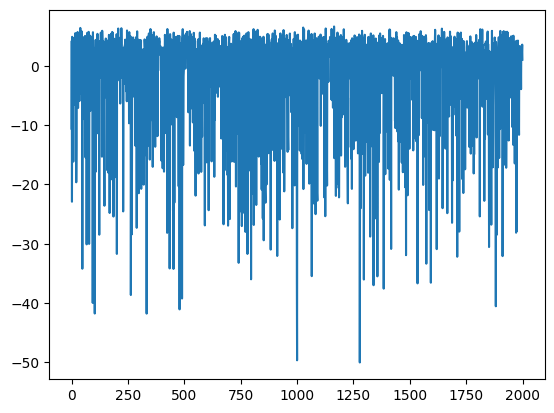

In [5]:
reward, pnl_T = train_and_adapt(0.04,0,2000)
episodes = np.arange(len(reward))
plt.plot(episodes, reward)

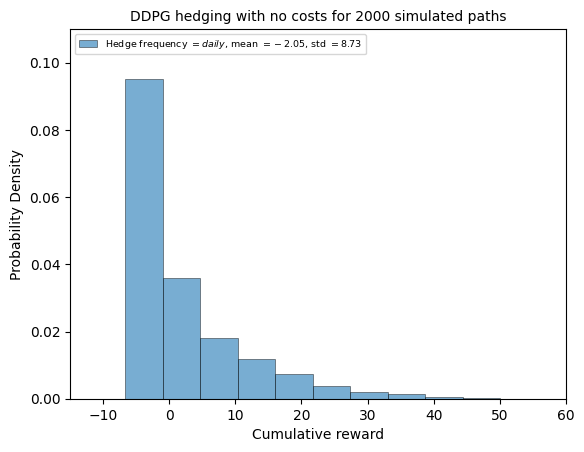

In [8]:
plt.hist(-np.array(reward), density=True, alpha=0.6, label='Hedge frequency $={time}$, mean $={mean}$, std $={std}$'.format(time='daily', mean=round(np.mean(reward),2), std=round(np.std(reward),2)), edgecolor='black', linewidth=0.5)
plt.xlabel("Cumulative reward")
plt.ylabel("Probability Density")
plt.legend(fontsize=6.8, loc="upper left")
plt.title("DDPG hedging with no costs for 2000 simulated paths", fontsize=10)
plt.xlim(-15,60)
plt.ylim(0,0.11)
# plt.savefig("ddpg_hedging_no_cost_cum_reward.jpg", dpi=600)
plt.show()